In [61]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [63]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [64]:
raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)


original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,oldpeak
0,63,1,1,145,233,1,2,150,0,3,0,6,2.3
1,67,1,4,160,286,0,2,108,1,2,3,3,1.5
2,67,1,4,120,229,0,2,129,1,2,2,7,2.6
3,37,1,3,130,250,0,0,187,0,3,0,3,3.5
4,41,0,2,130,204,0,2,172,0,1,0,3,1.4


In [65]:
cleveland_data = pd.read_csv("data/heart.csv")
cleveland_data["target"].value_counts()
    
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()
# cleveland_data.dtypes

1    165
0    138
Name: target, dtype: int64

In [66]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 15, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=25, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [67]:
## Need to define a scaling function that ignores categorical values...?

In [68]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                350       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________


In [69]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

In [70]:
# Separating a hold out set that will be used for validation later
X_train, y_train_orig, X_valid, y_valid_orig = split_valid(original_data, original_labels, valid_size=0.1)

y_train = training_labels[y_train_orig.index]
y_valid = training_labels[y_valid_orig.index]



In [71]:
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

def modKFold(n_splits, self=pipeline):
    from sklearn.model_selection import StratifiedKFold as KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 ) #Default = 10
    print("Running modified kfold...")
    X = self.train_set.features
    y = y_train_orig

    for train_index, test_index in kf.split(X,y):
        yield train_index, test_index

pipeline.getKFold = modKFold 
pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running modified kfold...
Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.450, Acc:0.8721
Prediction Accuracy
30/30 [==============================] - 0s 1ms/step
Scores on data set: loss=0.588 accuracy=0.8333
Fold Correct: 25
Running worker: 1
Fold: 1 -> Loss:0.517, Acc:0.8566
Prediction Accuracy
28/28 [==============================] - 0s 23us/step
Scores on data set: loss=0.536 accuracy=0.8214
Fold Correct: 23
Running worker: 2
Fold: 2 -> Loss:0.509, Acc:0.8450
Prediction Accuracy
27/27 [==============================] - 0s 24us/step
Scores on data set: loss=0.427 accuracy=0.9259
Fold Correct: 25
Running worker: 3
Fold: 3 -> Loss:0.528, Acc:0.8527
Prediction Accuracy
27/27 [==============================] - 0s 21us/step
Scores on data set: loss=0.544 accuracy=0.7407
Fold Correct: 20
Running worker: 4
Fold: 4 -> Loss:0.463, Acc:0.8885
Prediction Accuracy
26/26 [==============================] - 0s 17us/step
Scores on data set: loss=0.695 accuracy=0.7692
Fold Correc

Confusion matrix, without normalization
[[0.84722222 0.15277778]
 [0.20325203 0.79674797]]


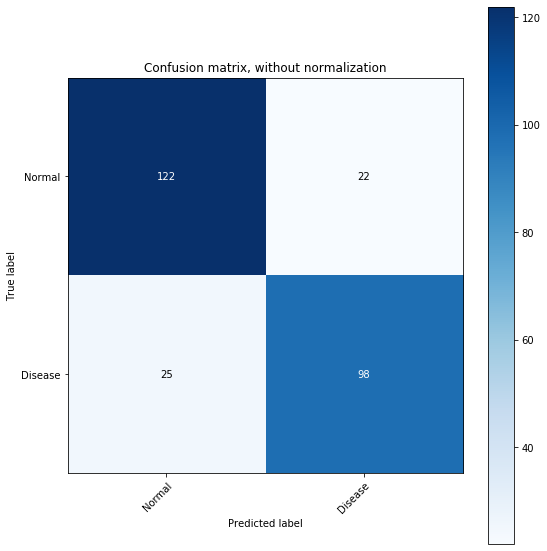

In [72]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [73]:
# min_cluster_sizes=range(10,17,1)
pipeline.train_clusterer(plot=False)

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.0,0.260912,0.260912
"(13, 12)",2,0.0,0.260912,0.260912
"(13, 13)",2,0.0,0.260912,0.260912
"(14, 12)",2,0.0,0.260912,0.260912
"(14, 13)",2,0.0,0.260912,0.260912
"(14, 14)",2,0.0,0.260912,0.260912
"(15, 12)",2,0.0,0.260912,0.260912
"(15, 13)",2,0.0,0.260912,0.260912
"(15, 14)",2,0.0,0.260912,0.260912
"(15, 15)",2,0.0,0.260912,0.260912


In [74]:
pd.Series(pipeline.clusterer.labels_).value_counts()

1    58
0    40
dtype: int64

In [75]:
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [76]:
pd.Series(cluster_labels).value_counts()

1    10
0     2
dtype: int64

## Plotting Testing LRP

In [77]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [78]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=3,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

# Comparing Subclusters to Original Data

In [79]:
y_train.head()

170    1
166    1
46     0
210    1
216    0
Name: target, dtype: int64

In [80]:
original_y = original_labels[y_train.index]
original_y.head()

170    1
166    1
46     0
210    3
216    0
Name: target, dtype: int64

In [81]:
y_train_orig.head()

170    1
166    1
46     0
210    3
216    0
Name: target, dtype: int64

In [82]:
y_train.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr].head()

234    1
130    0
14     0
109    1
204    1
Name: target, dtype: int64

In [83]:
# Get testing samples from cross validation
# That were correctly predicted
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
#And belong to target class
split_class = correct_pred_labels == pipeline.target_class

correct_original_target = original_y.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr][split_class]
correct_original_target.head()

In [84]:
emb3d["text"] = correct_original_target
emb3d["marker"]["color"] = correct_original_target
emb3d["marker"]["showscale"] = True
emb3d["marker"]["size"] = 5
emb3d["marker"]["colorscale"] = "Viridis"

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-vs-original.html')